# Algorithms for Data Science

## Counting Distinct Items

### 1. Preliminaries 

The objective of this lab is to implement the Flajolet-Martin approach to count distinct items. First, we generate an universe of $N$ strings of length $12$, and take $d$ items which will constitute our universe of distinct items.

In [38]:
import random
from string import ascii_lowercase

#parameters
N = 256 #universe of N 
d = 3 #distinct items
stream_size = 10000

#generate some random strings of size 10
U = []
for _ in range(N):
  U.append(''.join(random.choice(ascii_lowercase) for i in range(12)))

D = random.sample(U,k=d)

print(D)

['xgqfvqktoytw', 'rmjdisdxoptx', 'kompipwcxvcq']


### 2. Flajolet-Martin: Creating a Hash Function, Estimating Distinct Items Using Trailing 0s

In the following we create a hash function $h(x)$, which also takes as a parameter a hashable and $N$, and returns a value in $0,\dots,N-1$. We simulate a stream taking random values from $D$, count the trailing $0$s in its hash value, keep the maximum value $R$, and then output $2^R$ as the estimator.

In [5]:
import math
import random
from datetime import datetime

random.seed(datetime.now())

def h(x,n):
  return hash(x)%n

#method for counting trailing 0s
def trailing_0(x):
  x1 = x
  t0 = 0
  while x1%2==0 and x1!=0:
    t0 += 1
    x1 = int(x1/2)
  return t0

#simulating the stream
R = 0
for _ in range(stream_size):
  #take a random string from the distinct pool
  s = random.choice(D)
  #check its hash value
  hv = h(s,2*N) #to allow more space for hash values
  r = trailing_0(hv)
  if r>R: R=r

est = int(math.pow(2,R))

print('Estimation of distinct items: %d'%est)

Estimation of distinct items: 4


/var/folders/t5/hx7lxz7j0fl69fcp1hm17qfw0000gn/T/ipykernel_10299/2377552410.py:5: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now())


### 3. **TASK** Flajolet-Martin: Using Multiple Hash Functions

Implement the refined version of the above estimator, using multiple ($k$) hash functions (use the method of generating several pairs of numbers presented last time in the lab) and compute:
1. The average of the $k$ estimators
2. The median of the $k$ estimators
3. Divide the estimators into groups (vary the group size); take the median in each group and then the average over the groups.

Compare the three methods' final outputs. What do you notice?

_Note_: you can use the Python 3.4 _statistics_ package (not available in previous versions) to compute medians, averages, and other statistics.

In [14]:
import numpy as np
import random

p = 1223543677
n = 128
def h(x: str, a: int, b: int, p: int, n:int) -> int:
  '''
  description: set hash functions
  param {str} x 
  param {int} a
  param {int} b
  param {int} p
  param {int} n
  return {int} the hash value
  '''
  return ((a*hash(x)+b)%p)%n

def gen_hash_functions_params(k: int) -> list:

  '''
  description: generative the random parameters for hash functions
  param {int} k: number of hash functions
  return {list} a list of parameters
  '''
  
  hash_functions_params = []
  for i in range(k):
    a = random.randrange(p)
    b = random.randrange(p)
    hash_functions_params.append([a, b])
  return hash_functions_params


def get_estimation_distinct_items(D: list, stream_size: int, hash_functions_params: list) -> list:
  '''
  description: get a list of estimation values of dictinct items.
  param {list} D
  param {int} stream_size
  param {list} hash_functions_params
  return {list} a list of estimations of distinct items
  '''
  #simulating the stream
  est_list = []
  R_list = [0]*len(hash_functions_params)
  for _ in range(stream_size):
    #take a random string from the distinct pool
    s = random.choice(D)
    #check its hash value
    for j, val in enumerate(hash_functions_params):
      a = val[0]
      b = val[1]
      hv = h(s,a,b,p,n)
      r = trailing_0(hv)
      if r > R_list[j]: 
        R_list[j]=r

  for R in R_list:
    est = int(math.pow(2,R))
    est_list.append(est)
    
  return est_list


k = 50
average_est_list = []
median_est_list = []
# generate i random pairwise independent hash functions
for j in range(1, k):
  hash_functions_params = gen_hash_functions_params(j)
  est_list = get_estimation_distinct_items(D, stream_size, hash_functions_params)
  average_est = np.mean(np.array(est_list))
  medians_est = np.median(np.array(est_list))
 
  average_est_list.append(average_est)
  median_est_list.append(medians_est)


I implemented the refined version of the above estimator, using multiple k hash functions, using k form 1-50, computed the 1). The average of the $k$ estimators 2). The median of the $k$ estimators as shown below.

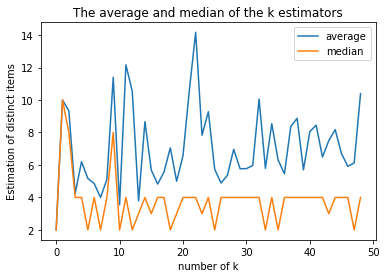

In [15]:
import matplotlib.pyplot as plt
plt.plot(average_est_list, label="average")
plt.plot(median_est_list, label="median")
plt.title("The average and median of the k estimators")
plt.ylabel('Estimation of distinct items')
plt.xlabel('number of k')
plt.legend()

I divided the estimators into groups, I chose group size from 1-9, and then took the median in each group and then the average over the groups.

In [41]:
# we take k = 10, 20, 30, 50 in order to plot clearly.
k_list = [10, 20, 30, 50]

median_est_list = []
all_k_with_all_average = []
for k in k_list:
  # for each k, we will split to group size 1-9 respectively
  all_average = []
  for group_size in range(1, 10):
    for i in range(1, k, group_size):
      num_hash = int(k/group_size)
      hash_functions_params = gen_hash_functions_params(num_hash)
      est_list = get_estimation_distinct_items(D, stream_size, hash_functions_params)

      medians_est = np.median(np.array(est_list))
      median_est_list.append(medians_est)
    
    average_est_over_groups = np.mean(np.array(median_est_list))
    all_average.append(average_est_over_groups)
  all_k_with_all_average.append(all_average)

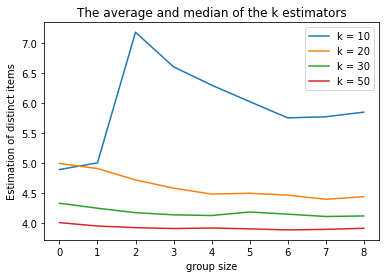

In [42]:
for i, all_average in enumerate(all_k_with_all_average):
    plt.plot(all_average, label="k = {}".format(k_list[i]))
    plt.title("The average and median of the k estimators")
    plt.ylabel('Estimation of distinct items')
    plt.xlabel('group size')
    plt.legend()
plt.show()

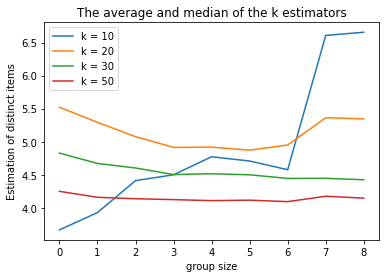

In [40]:
for i, all_average in enumerate(all_k_with_all_average):
    plt.plot(all_average, label="k = {}".format(k_list[i]))
    plt.title("The average and median of the k estimators")
    plt.ylabel('Estimation of distinct items')
    plt.xlabel('group size')
    plt.legend()
plt.show()

# Discussion

If I only use one hash function, the expectation E[2^R] can get very high. I fixed it by using multiple estimators, there are k different hash functions. I computed k up to 50 to see the performance. Then I took median, average respectively as shown above in the first picture. 

For average values plot, it varies a lot compared to the median values plot. We can see when k is lager than 5, the median values plot starts to get more stable. The values of the median are about 3, which is the actual estimation of distinct items.
On the other hand, the average values plot did not get stable and the values are higher than the actual estimations. It is because that taking the average can overestimate as one estimator maybe an
outlier.

Taking the median is better, but it is always a power of 2, so I took the hybrid. It divided the hash functions in groups, then computed average in each group, took the median over groups as shown in the second picture. I chose k=10, 20, 30, 50 to plot. We can see when k is larger than 10, the values get stable with the group size changes. Also, when k gets larger, the values are more close to the actual estimation of distinct items.